In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
from typing import Tuple, Optional
df_predictions = pd.read_csv("data/cleaned/predictions.csv")
df_inventory = pd.read_excel("data/raw/catusita/inventory.xlsx")
df_rfm = pd.read_csv("data/process/df_rfm.csv")
df_tc = pd.read_excel("data/raw/catusita/saldo de todo 04.11.2024.2.xls", skiprows=2)
df_products = pd.read_csv("data/process/catusita_consolidated.csv")
try:
    df_backorder = pd.read_excel("/data/raw/catusita/backorder12_12.xlsx")
except FileNotFoundError:
    df_backorder = pd.DataFrame()

### to_datime
df_tc['Ult. Fecha'] = pd.to_datetime(df_tc['Ult. Fecha'], errors='coerce')
df_products['fecha'] = pd.to_datetime(df_products['fecha'])
df_predictions['date'] = pd.to_datetime(df_predictions['date'])
df_inventory['FECHA AL'] = pd.to_datetime(df_inventory['FECHA AL'], format='%Y%m%d')

### processing data for raw tables
## df_tc
df_tc = df_tc[['Código','Mnd','Fob','Ult. Fecha','Ult. Compra']]
df_tc.columns = ['codigo', 'moneda', 'monto', 'ultima_fecha', 'ultima_compra']
df_tc['codigo'] = df_tc['codigo'].astype(str)
df_tc = df_tc.dropna(subset=['ultima_fecha'])
df_tc['codigo'] = df_tc['codigo'].str.lower()
df_tc = df_tc[df_tc['ultima_fecha'].notna()]

## df_product
df_products['fecha_mensual'] = df_products['fecha'].dt.to_period('M').dt.to_timestamp()       
# crear variable precio
df_products['precio'] = df_products['venta_pen'] / df_products['cantidad']
# crear variable margen
df_products['margen'] = df_products['venta_pen'] / df_products['costo'] - 1
df_margin_result = df_products.groupby('articulo').agg(
    total_venta_pen=('venta_pen', 'sum'),
    mean_margen=('margen', 'mean')
).reset_index().sort_values(by='total_venta_pen', ascending=False)
# agregar por fecha_mensual, articulo, fuente_suministro 
df_products = df_products.groupby(['fecha_mensual', 'articulo', 'fuente_suministro']).agg({
    'codigo': 'first', 
    'cantidad': 'sum',
    'transacciones': 'sum',
    'venta_pen': 'sum', 
    'costo': 'mean',
    'precio': 'mean',
    'lt': 'first'
}).reset_index().rename(columns={'venta_pen': 'total_venta_pen','margen': 'mean_margen'})

## df_predictions
df_predictions = df_predictions.rename(columns={'sku': 'articulo'})

## df_inventory
df_inventory.columns = ['cia', 'date', 'codigo', 'descripcion', 'um', 'stock']
df_inventory.loc[:, 'codigo'] = df_inventory['codigo'].str.lower()
df_inventory = df_inventory.groupby(['date','codigo','descripcion','um']).agg(
    {
        'stock':'sum'
    }
).reset_index()

# Get currency data 
start = df_tc['ultima_fecha'].min().date()
end = df_tc['ultima_fecha'].max().date()
currency_pairs = ['PENUSD=X', 'EURUSD=X', 'JPYUSD=X', 'GBPUSD=X']
data = yf.download(currency_pairs, start=start, end=end)
df_closing_prices = data['Close']
df_closing_prices.columns = [col.split('.')[0] for col in df_closing_prices.columns]

# process currency data
df_long_format = df_closing_prices.reset_index().melt(id_vars='Date', var_name='Currency Pair', value_name='Closing Price')
df_long_format['Currency Pair'] = df_long_format['Currency Pair'].str.replace('=X', '', regex=False)
df_long_format = df_long_format.dropna(subset=['Closing Price'])

full_date_range = pd.date_range(start=df_long_format['Date'].min(), end=df_long_format['Date'].max(), freq='D')
currency_pairs = df_long_format['Currency Pair'].unique()
complete_index = pd.MultiIndex.from_product([full_date_range, currency_pairs], names=['Date', 'Currency Pair'])
df_temp = pd.DataFrame(index=complete_index).reset_index()

df_long_format = df_temp.merge(df_long_format, on=['Date', 'Currency Pair'], how='left')
df_long_format['Closing Price'] = df_long_format.groupby('Currency Pair')['Closing Price'].ffill()
df_long_format = df_long_format.rename(columns={'Closing Price': 'tc'})

# merge exchange rates
df_tc_merged = pd.merge(df_tc, df_long_format, left_on='ultima_fecha', right_on='Date', how='left')
df_tc_merged['monto'] = pd.to_numeric(df_tc_merged['monto'], errors='coerce')
df_tc_merged['tc'] = pd.to_numeric(df_tc_merged['tc'], errors='coerce')

def convert_to_usd(row):
    if pd.isna(row['Currency Pair']) or row['moneda'] == 'USD':
        return row['monto']
    currency_pair_map = {'SOL': 'PENUSD', 'EUR': 'EURUSD', 'JPY': 'JPYUSD', 'GBP': 'GBPUSD'}
    if row['moneda'] in currency_pair_map and row['Currency Pair'] == currency_pair_map[row['moneda']]:
        return row['monto'] / row['tc'] if row['moneda'] == 'SOL' else row['monto'] * row['tc']
    return 0

df_tc_merged['monto_usd'] = df_tc_merged.apply(convert_to_usd, axis=1)
df_tc_merged = df_tc_merged[df_tc_merged['monto_usd'] != 0]
df_tc_final = df_tc_merged[['codigo', 'ultima_fecha', 'monto_usd', 'ultima_compra']]
df_tc_final = df_tc_final[df_tc_final['monto_usd'].notna()]

# cleaning df_inventory with df_products
max_date = df_inventory['date'].max()
df_inventory = df_inventory[
    (df_inventory['date'] != 'Periodo') & 
    (df_inventory['date'].notna())&
    (df_inventory['date']==max_date)
]
df_inventory_final=pd.concat(
    [
        pd.DataFrame(df_inventory['codigo'].unique(), columns=['codigo']),
        pd.DataFrame(df_products['articulo'].unique(), columns=['codigo'])
    ], 
    ignore_index=True
).drop_duplicates()
df_inventory = df_inventory_final.merge(
    df_inventory[['date','codigo','stock','descripcion']].drop_duplicates(),
    how='left',
    on='codigo'
)
df_inventory['stock']=df_inventory['stock'].fillna(0)
df_inventory['date'] = df_inventory['date'].fillna(max_date)
# merging df_predictions, df_products and df_invetory
df_merged = df_predictions.copy()
df_merged = df_merged.merge(
    df_products[['articulo','fuente_suministro']].drop_duplicates(), 
    how='left', 
    on = 'articulo'
)
df_merged = df_merged.merge(
    df_inventory[['codigo','stock','descripcion']], 
    how='left', 
    left_on=['articulo'],
    right_on=['codigo']
)

# merging df_tc_final, df_backorder, rfm and df_margin_result
df_merged = df_merged.merge(
    df_margin_result[['articulo', 'mean_margen']], 
    how='left', 
    on='articulo'
)
df_merged = df_merged.merge(
    df_tc_final, 
    how='left', 
    left_on='articulo', 
    right_on='codigo'
)
if not df_backorder.empty:
    df_merged = df_merged.merge(
        df_backorder, 
        how='left', 
        on='articulo'
    )
else:
    df_merged['backorder'] = np.nan

df_merged['backorder'] = df_merged['backorder'].fillna(0)

df_merged = df_merged.merge(
    df_rfm, 
    left_on='articulo',
    right_on='sku',
    how='left'
)
df_merged['rfm'] = df_merged['rfm'].fillna(0).astype(int)
df_merged = df_merged.drop_duplicates()

# adding demanda_mensual and meses_proteccion    
df_merged['demanda_mensual'] = df_merged['caa'] / df_merged['lt']
df_merged['meses_proteccion'] = df_merged['corr_sd'] / df_merged['demanda_mensual']

# adding compra_sugerida
df_merged['sobrante'] = np.maximum(df_merged['stock'] + df_merged['backorder'] - df_merged['caa_lt'], 0)
df_merged['compra_sugerida'] = np.maximum(df_merged['caa'] - df_merged['sobrante'], 0)
df_merged['compra_sugerida'] = np.ceil(df_merged['compra_sugerida']).astype('Int64')
df_merged['compra_sugerida'] = df_merged['compra_sugerida'].astype("Float64")
df_merged['meses_proteccion'] = df_merged['meses_proteccion'].astype("Float64")
# mask = df_merged['demanda_mensual'] != 0
# df_merged.loc[mask, 'meses_proteccion'] = (
#     df_merged.loc[mask, 'meses_proteccion'] * 
#     (df_merged.loc[mask, 'compra_sugerida'].fillna(0) / df_merged.loc[mask, 'demanda_mensual'])
# ).astype("Float64")

# adding costo_compra and compras_recomendadas
df_merged = df_merged.rename(columns={'caa': 'compras_recomendadas'})
# df_merged = df_merged.rename(columns={'compra_sugerida': 'compras_recomendadas'})
df_merged.loc[df_merged['demanda_mensual'] < 0, 'demanda_mensual'] = 0
df_merged.loc[df_merged['compras_recomendadas'] < 0, 'compras_recomendadas'] = 0
df_merged['compras_recomendadas'] = df_merged['compras_recomendadas'].apply(
    lambda x: math.ceil(x / 50) * 50 if pd.notna(x) else pd.NA
)
df_merged['costo_compra'] = df_merged['monto_usd'] * df_merged['compras_recomendadas']

# Calcular riesgo
df_merged['holgura'] = (df_merged['stock'] / df_merged['demanda_mensual']).fillna(0)
df_merged['consumiendo_proteccion'] = (df_merged['holgura'] < df_merged['meses_proteccion']).astype('Int64')
df_merged['quebro'] = (df_merged['holgura'] <= 0).astype('Int64')
df_merged['va_a_quebrar'] = ((df_merged['stock'] + df_merged['backorder']) < df_merged['demanda_mensual']).astype('Int64')
df_merged['verde'] = (
    (df_merged['quebro'] == 0) & 
    (df_merged['consumiendo_proteccion'] == 0) & 
    (df_merged['va_a_quebrar'] == 0)
).astype('Int64')
df_merged['amarillo'] = (
    (df_merged['consumiendo_proteccion'] == 1) & 
    (df_merged['quebro'] == 0)
).astype('Int64')
df_merged['rojo'] = (
    (df_merged['quebro'] == 1) |
    (df_merged['va_a_quebrar'] == 1) 
).astype('Int64')
df_merged['riesgo'] = df_merged.apply(
    lambda row: 'rojo' if pd.notna(row.get('rojo')) and row['rojo'] == 1 else 
                'amarillo' if pd.notna(row.get('amarillo')) and row['amarillo'] == 1 else 
                ('verde' if pd.notna(row.get('rojo')) or pd.notna(row.get('amarillo')) else np.nan),
    axis=1
)

# modificar period2 (caa_lt)
df_merged['caa_lt'] += df_merged['corr_sd'] * df_merged['rfm'].map({3: 0.4, 2: 0.3, 1: 0.2, 0: 0.1}).fillna(0)

# filtrar solo las importantes para la tabla por fuente de suministro
df_merged['demanda_mensual_usd'] = df_merged['demanda_mensual'] * df_merged['monto_usd']
df_temp = df_merged.copy()
df_temp = df_temp[(df_temp['rfm'] == 3) & (df_temp['riesgo'] == 'rojo')]
df_temp = df_temp.groupby('fuente_suministro').agg(
    recomendacion=('costo_compra', 'sum'),
    demanda_mensual_usd=('demanda_mensual_usd', 'sum')
).reset_index()
df_temp_2 = df_merged.groupby('fuente_suministro').agg(
    lead_time=('lt', 'first'),
    riesgo=('riesgo', lambda x: x.mode()[0] if not x.mode().empty else None)
).reset_index()
df_dashboard_by_fuente = df_temp_2.merge(df_temp, how='left', on='fuente_suministro')
df_dashboard_by_fuente['recomendacion'] = pd.to_numeric(df_dashboard_by_fuente['recomendacion'], errors='coerce').fillna(0).astype(int)
df_dashboard_by_fuente['demanda_mensual_usd'] = pd.to_numeric(df_dashboard_by_fuente['demanda_mensual_usd'], errors='coerce').fillna(0).astype(int)


[*********************100%***********************]  4 of 4 completed


       articulo         fuente_suministro                          descripcion
1916  paw68a500  prextoline - lubricantes  ACEITE AW68 PREXTOFLUID ISO68 AMBAR


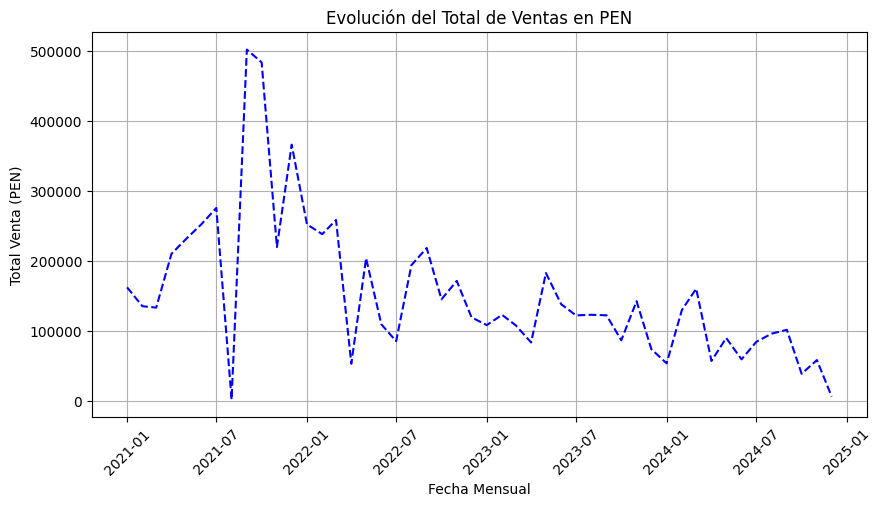

In [49]:
import matplotlib.pyplot as plt
articulo_mas_venta = df_margin_result.iloc[0]['articulo']
df_ppt = df_products.merge(df_inventory[['codigo','descripcion']], how='left',left_on='articulo',right_on='codigo')
df_ppt = df_ppt[df_ppt['articulo']==articulo_mas_venta]
print(df_ppt[df_ppt['articulo']==articulo_mas_venta][['articulo','fuente_suministro','descripcion']].head(1))

# Graficar la evolución con una línea conectando los puntos
plt.figure(figsize=(10,5))
plt.plot(df_ppt["fecha_mensual"], df_ppt["total_venta_pen"], linestyle="--", color="b")

# Etiquetas y título
plt.xlabel("Fecha Mensual")
plt.ylabel("Total Venta (PEN)")
plt.title("Evolución del Total de Ventas en PEN")
plt.grid(True)

# Mostrar el gráfico
plt.xticks(rotation=45)
plt.show()

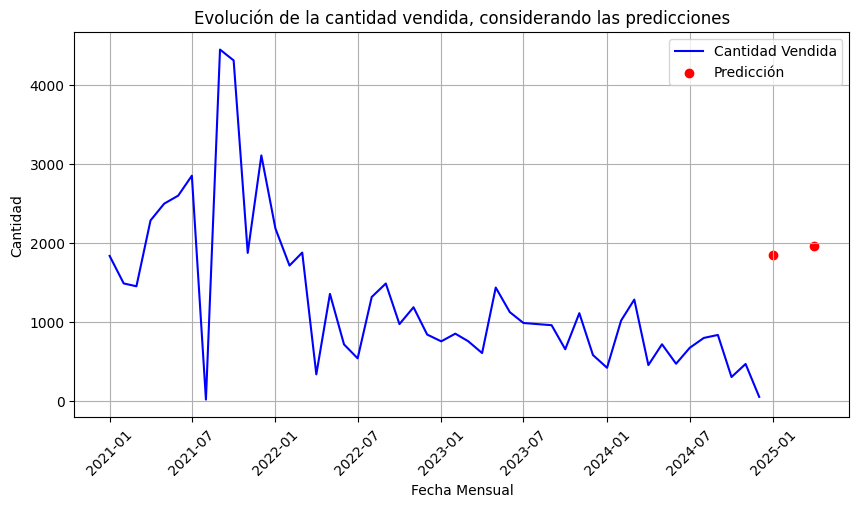

In [102]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar el DataFrame con el artículo más vendido
df_ppt2 = df_products[df_products['articulo'] == articulo_mas_venta][['fecha_mensual', 'articulo', 'cantidad']]

# Convertir la fila de df_ppt3 en columnas separadas
df_ppt3_original = df_merged[df_merged['articulo'] == articulo_mas_venta][['compras_recomendadas', 'caa_lt']]

# Transformar en formato adecuado (2 filas en lugar de 1)
df_ppt3 = pd.DataFrame({
    "fecha_mensual": pd.to_datetime(["2025-01-01", "2025-04-01"]),
    "cantidad": [df_ppt3_original["compras_recomendadas"].values[0], df_ppt3_original["caa_lt"].values[0]]
})

# Graficar la evolución con una línea conectando los puntos
plt.figure(figsize=(10,5))
plt.plot(df_ppt2["fecha_mensual"], df_ppt2["cantidad"], linestyle="-", color="b", label="Cantidad Vendida")

# Agregar los puntos de predicción con las fechas correctas
plt.scatter(df_ppt3["fecha_mensual"], df_ppt3["cantidad"], color="r", marker="o", label="Predicción")

# Etiquetas y título
plt.xlabel("Fecha Mensual")
plt.ylabel("Cantidad")
plt.title("Evolución de la cantidad vendida, considerando las predicciones")
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.xticks(rotation=45)
plt.show()


In [103]:
df_merged[df_merged['articulo'] == articulo_mas_venta][['articulo',
    'stock', 'lt', 'backorder', 'compras_recomendadas', 'caa_lt', 
    'sobrante', 'compra_sugerida', 'meses_proteccion'
]].rename(columns={'compras_recomendadas': 'caa_lt','caa_lt':'caa_2lt','compra_sugerida':'compra_sugerida'}).to_csv('prediccion_articulo_mas_vendido.csv')


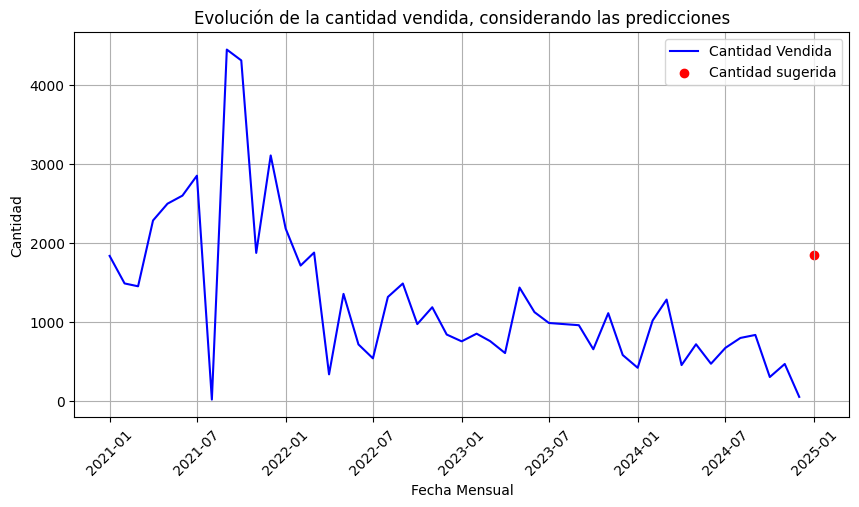

In [101]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar el DataFrame con el artículo más vendido
df_ppt2 = df_products[df_products['articulo'] == articulo_mas_venta][['fecha_mensual', 'articulo', 'cantidad']]

# Convertir la fila de df_ppt3 en columnas separadas
df_ppt3_original = df_merged[df_merged['articulo'] == articulo_mas_venta][['compra_sugerida', 'caa_lt']]

# Transformar en formato adecuado (2 filas en lugar de 1)
df_ppt3 = pd.DataFrame({
    "fecha_mensual": pd.to_datetime(["2025-01-01"]),
    "cantidad": [df_ppt3_original["compra_sugerida"].values[0]]
})

# Graficar la evolución con una línea conectando los puntos
plt.figure(figsize=(10,5))
plt.plot(df_ppt2["fecha_mensual"], df_ppt2["cantidad"], linestyle="-", color="b", label="Cantidad Vendida")

# Agregar los puntos de predicción con las fechas correctas
plt.scatter(df_ppt3["fecha_mensual"], df_ppt3["cantidad"], color="r", marker="o", label="Cantidad sugerida")

# Etiquetas y título
plt.xlabel("Fecha Mensual")
plt.ylabel("Cantidad")
plt.title("Evolución de la cantidad vendida, considerando las predicciones")
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.xticks(rotation=45)
plt.show()


In [112]:
df_predictions2 = pd.read_csv("data/cleaned/predictions.csv")
df_predictions2[df_predictions2['sku'] == articulo_mas_venta]

,sku,lt,date,model,real,catusita,lookback_period,features_used,caa,caa_lt,corr_sd,loss
2556,paw68a500,2,2025-01-01,mean,0,523.166667,6.0,"Hibridos y Electricos,Livianos,Menores,Pesados...",1845.666667,1845.666667,279.245064,200.0


In [119]:
df_products[df_products['articulo'] == articulo_mas_venta].sort_values('fecha_mensual',ascending=False).head(6)

,fecha_mensual,articulo,fuente_suministro,codigo,cantidad,transacciones,total_venta_pen,costo,precio,lt
121574,2024-12-01,paw68a500,prextoline - lubricantes,c08747,54.0,2,6528.47,2192.980000,123.524150,2.0
120118,2024-11-01,paw68a500,prextoline - lubricantes,c10584,470.0,27,58562.58,1416.185927,128.436885,2.0
117128,2024-10-01,paw68a500,prextoline - lubricantes,c14514,305.0,26,39001.46,955.908461,130.127218,2.0
114377,2024-09-01,paw68a500,prextoline - lubricantes,c13621,837.0,36,101765.23,1931.372500,126.266993,2.0
111438,2024-08-01,paw68a500,prextoline - lubricantes,c14677,799.0,39,96249.06,1676.826923,124.494326,2.0
108450,2024-07-01,paw68a500,prextoline - lubricantes,c14946,674.0,35,84600.35,1576.097144,127.166800,2.0


In [134]:
df_temp = df_products[df_products['articulo'] == articulo_mas_venta].sort_values('fecha_mensual',ascending=False).head(12)
df_temp.tail(6)['cantidad'].mean()

np.float64(728.8333333333334)

In [ ]:
import requests
import pandas as pd

# URL de la API
url = "http://api.catusita.com:8083/api/sales/forDate"

# Parámetros de la consulta
params = {
    "Date1": "20250101",
    "Date2": "20250115"
}

# Encabezados opcionales (puedes agregar más si la API lo requiere)
headers = {
    "Accept": "application/json"  # Asegura que la API devuelva JSON
}

try:
    # Hacer la solicitud GET a la API
    response = requests.get(url, params=params, headers=headers, timeout=10)

    # Verificar si la respuesta fue exitosa
    response.raise_for_status()  # Lanza un error si la respuesta no es 200

    # Intentar convertir la respuesta en JSON
    try:
        data = response.json()
        print(data)  # Imprime los datos obtenidos
    except ValueError:
        print("⚠️ La respuesta no es un JSON válido.")

except requests.exceptions.RequestException as e:
    print(f"❌ Error al conectar con la API: {e}")


# Extraer la lista de datos desde el JSON
data_list = data.get("data", [])  # Asegura que no falle si la clave "data" no existe

# Convertir a DataFrame
df = pd.DataFrame(data_list)

df


{'data': [{'dateDocument': '2025-01-13T00:00:00', 'document': 'F001-01-0059747', 'codeArticle': 'RXFC113640BEP', 'nameArticle': 'LIQUIDO DE FRENO DOT3 12 onzas PLASTICO', 'codeSupply': 'C310', 'nameSupply': 'WAGNER LOCKED - USA', 'quantity': 24, 'amountSOL': 214.64, 'amountUSD': 56.95, 'cost': 125.7}, {'dateDocument': '2025-01-13T00:00:00', 'document': 'F001-01-0059747', 'codeArticle': 'RXFC113644BEP', 'nameArticle': 'LIQUIDO DE FRENO DOT4 1LT 32 onzas PLASTICO', 'codeSupply': 'c310', 'nameSupply': 'WAGNER LOCKED - USA', 'quantity': 24, 'amountSOL': 651.58, 'amountUSD': 172.88, 'cost': 402.6}, {'dateDocument': '2025-01-13T00:00:00', 'document': 'F001-01-0059747', 'codeArticle': 'RXFC113641BEP', 'nameArticle': 'LIQUIDO DE FRENO DOT3 1LT 32 oz 946ml PLASTICO', 'codeSupply': 'C310', 'nameSupply': 'WAGNER LOCKED - USA', 'quantity': 24, 'amountSOL': 459.93, 'amountUSD': 122.03, 'cost': 280.630008}, {'dateDocument': '2025-01-13T00:00:00', 'document': 'F001-01-0059747', 'codeArticle': 'RXFC11

In [6]:
df

,dateDocument,document,codeArticle,nameArticle,codeSupply,nameSupply,quantity,amountSOL,amountUSD,cost
0,2025-01-13T00:00:00,F001-01-0059747,RXFC113640BEP,LIQUIDO DE FRENO DOT3 12 onzas PLASTICO,C310,WAGNER LOCKED - USA,24,214.64,56.95,125.700000
1,2025-01-13T00:00:00,F001-01-0059747,RXFC113644BEP,LIQUIDO DE FRENO DOT4 1LT 32 onzas PLASTICO,c310,WAGNER LOCKED - USA,24,651.58,172.88,402.600000
2,2025-01-13T00:00:00,F001-01-0059747,RXFC113641BEP,LIQUIDO DE FRENO DOT3 1LT 32 oz 946ml PLASTICO,C310,WAGNER LOCKED - USA,24,459.93,122.03,280.630008
3,2025-01-13T00:00:00,F001-01-0059747,RXFC113661BEP,LIQUIDO DE FRENO DOT4 12 onzas PLASTICO,C310,WAGNER LOCKED - USA,24,283.62,75.25,173.980008
4,2025-01-10T00:00:00,F001-01-0059718,RXFC113644BEP,LIQUIDO DE FRENO DOT4 1LT 32 onzas PLASTICO,c310,WAGNER LOCKED - USA,36,942.89,250.17,603.900000
...,...,...,...,...,...,...,...,...,...,...
5538,2025-01-10T00:00:00,F007-07-0005519,4852009M80,AMORTIGUADOR DEL LH 339032,B975,ITO KOYAMA - AMORTIGUADORES,-1,-101.56,-26.94,-51.630000
5539,2025-01-10T00:00:00,F007-07-0005519,543020322R,AMORTIGUADOR DEL RH LH,B975,ITO KOYAMA - AMORTIGUADORES,-2,-168.44,-44.68,-86.930000
5540,2025-01-09T00:00:00,F007-07-0005511,54302-54Y00,AMORTIGUADOR DEL RH 633115,B975,ITO KOYAMA - AMORTIGUADORES,-2,-155.19,-40.85,-84.720000
5541,2025-01-14T00:00:00,F007-07-0005523,DPM12.00R20,LLANTAS DERUIBO DRB599 22PR SET,B650,DERUIBO,-2,-1909.71,-505.08,-1548.880000
